### Student Information
Name: Jaden 劉家成

Student ID: 108062182

GitHub ID: jadenliu12

Kaggle name: Jaden Liu

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2022-Lab2-master Repo](https://github.com/keziatamus/DM2022-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm2022-isa5810-lab2-homework) regarding Emotion Recognition on Twitter. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 15th 11:59 pm, Tuesday)__. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 18th 11:59 pm, Friday)__. 

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        # tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.set_visible_devices([], 'GPU') # Apple M-1 Pro bug with tensorflow workaround (use CPU)

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Init Plugin
1 Physical GPUs, 0 Logical GPUs
Init Graph Optimizer
Init Kernel


# Part 1 (Complete Take Home Exercise)

## 1.1 Load data

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [3]:
import pandas as pd

### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [4]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [5]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [6]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [7]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


<AxesSubplot:>

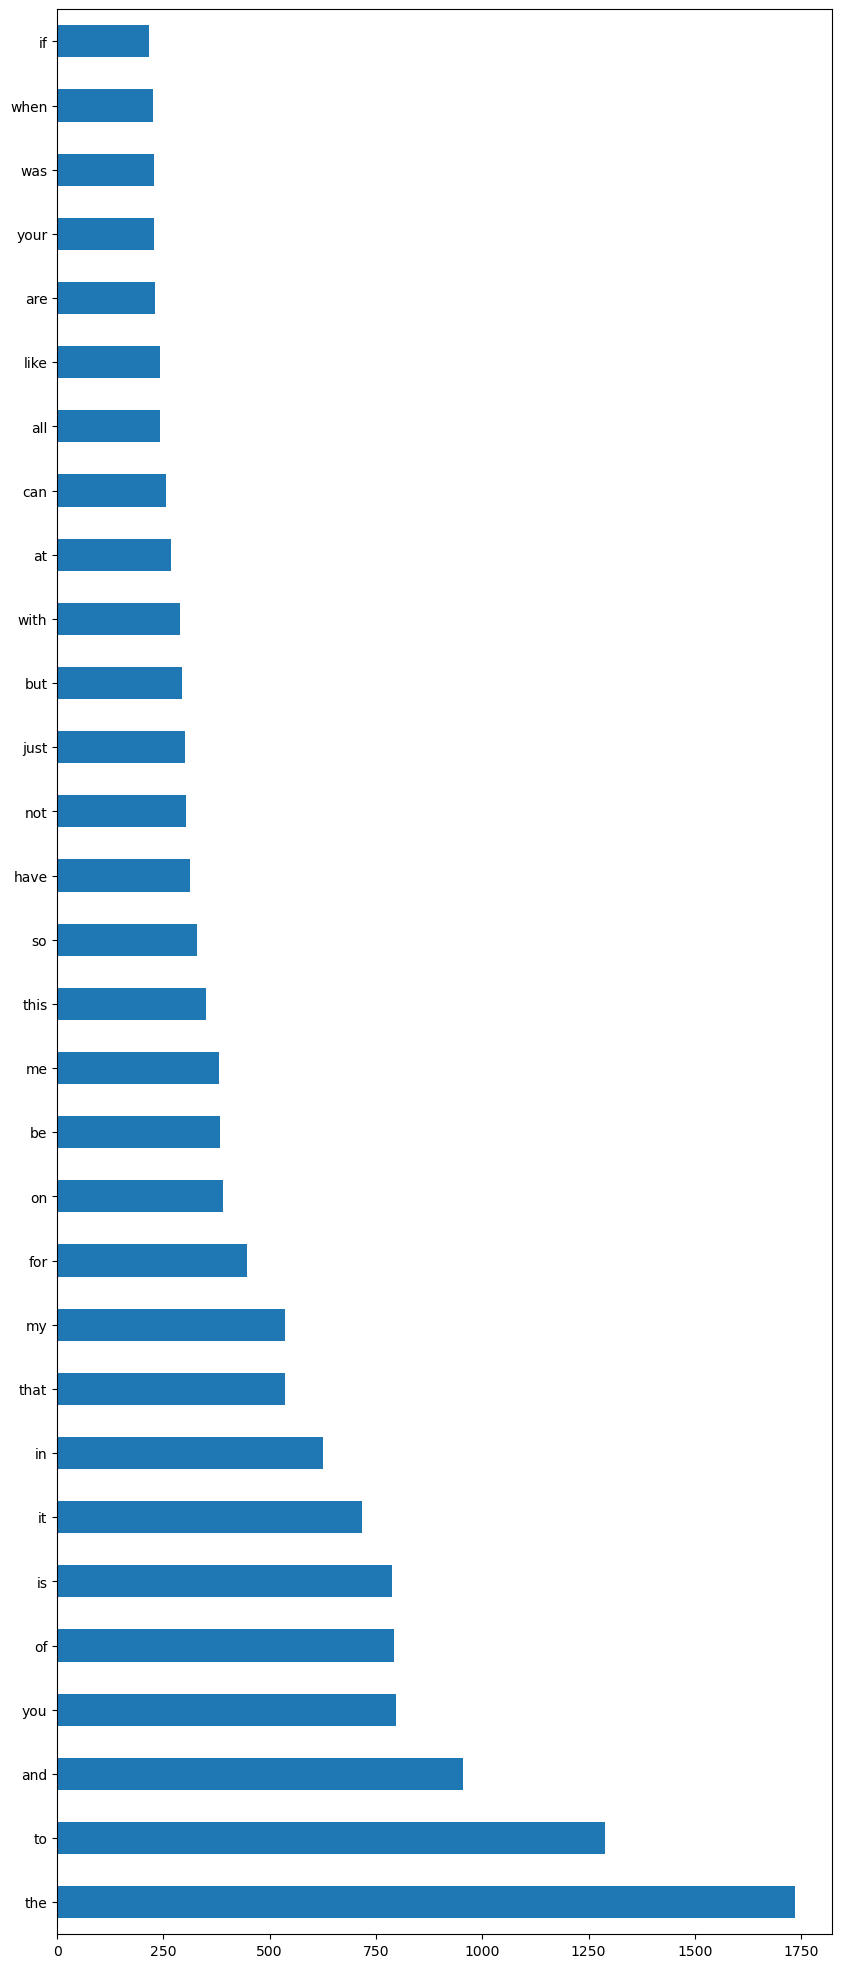

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Train df top 30 words
count_vect = CountVectorizer()
train_x_counts = count_vect.fit_transform(train_df.text)

df = pd.DataFrame(train_x_counts.todense()) 
df.columns = count_vect.get_feature_names_out()
term_document_matrix = df.T
term_document_matrix.columns = ["doc_"+ str(i) for i in list(train_df.index)]
term_document_matrix['total_count'] = term_document_matrix.sum(axis=1)

train_top_30 = term_document_matrix.sort_values(by ='total_count',ascending=False)[:30] 
train_top_30['total_count'].plot.barh(figsize = (10,25))

<AxesSubplot:>

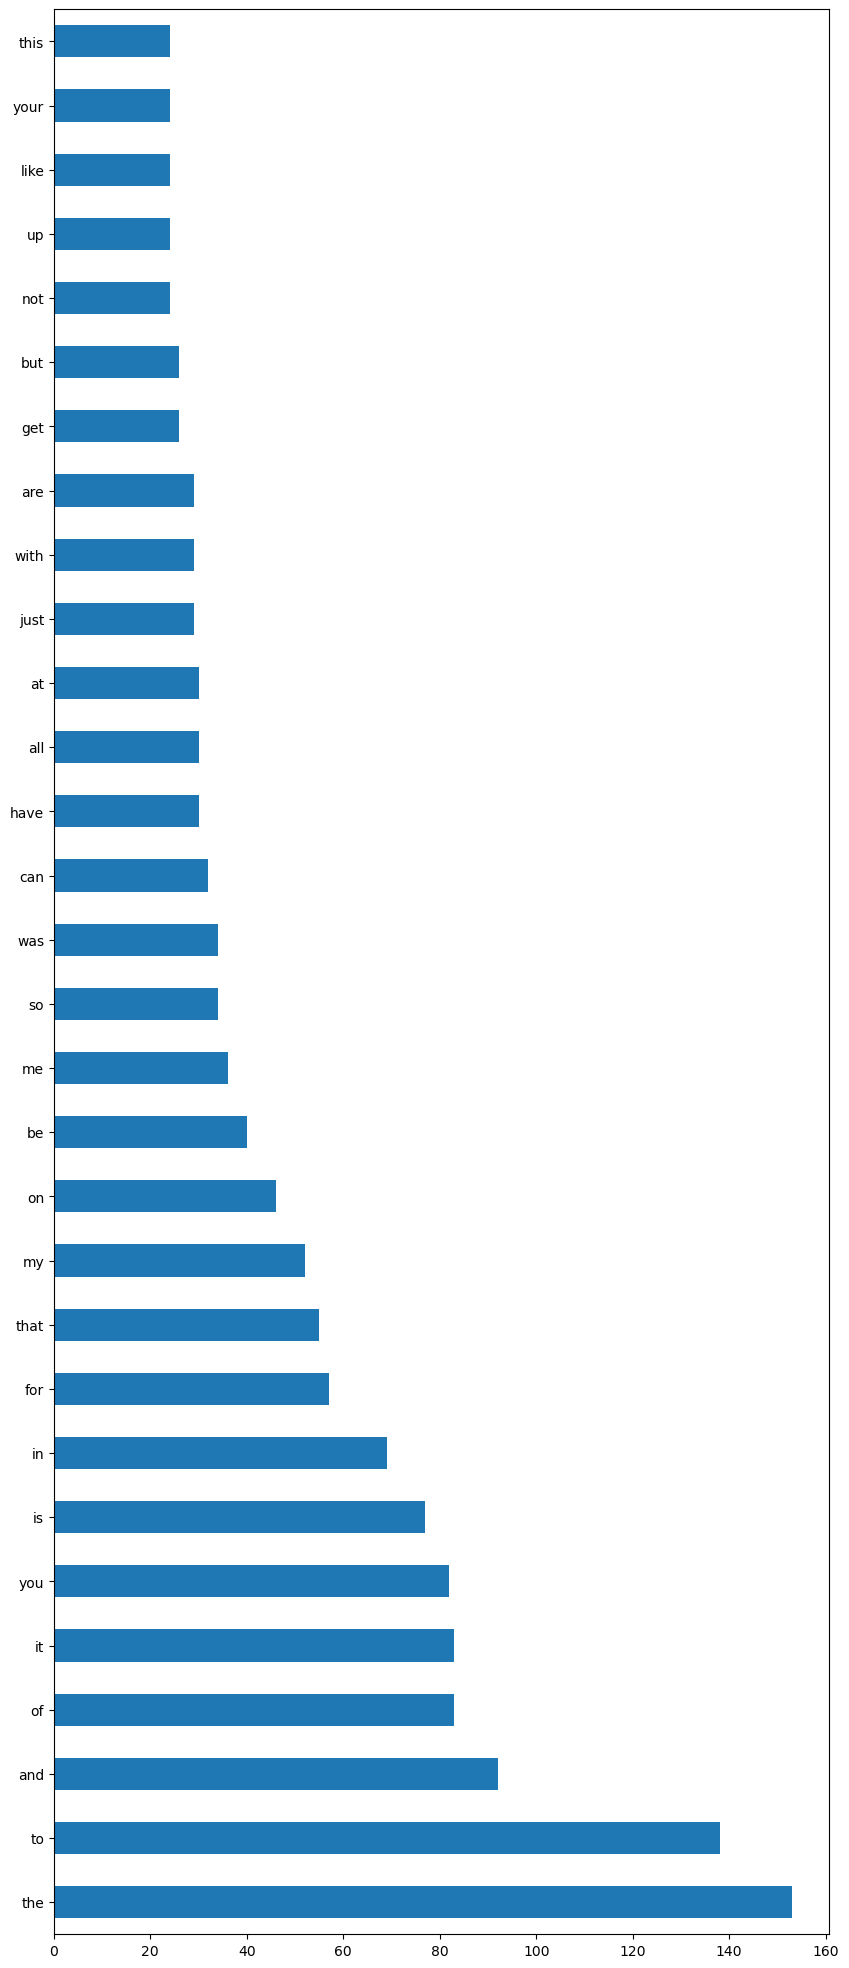

In [9]:
# Test df top 30 words
count_vect = CountVectorizer()
test_x_counts = count_vect.fit_transform(test_df.text)

df = pd.DataFrame(test_x_counts.todense()) 
df.columns = count_vect.get_feature_names_out()
term_document_matrix = df.T
term_document_matrix.columns = ["doc_"+ str(i) for i in list(test_df.index)]
term_document_matrix['total_count'] = term_document_matrix.sum(axis=1)

test_top_30 = term_document_matrix.sort_values(by ='total_count',ascending=False)[:30] 
test_top_30['total_count'].plot.barh(figsize = (10,25))

---
### 1.2 Save data

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [10]:
## save to pickle file
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

In [11]:
import pandas as pd

## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

---
### 1.3 Exploratory data analysis (EDA)

Again, before getting our hands dirty, we need to explore a little bit and understand the data we're dealing with.

In [12]:
#group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: text, dtype: int64

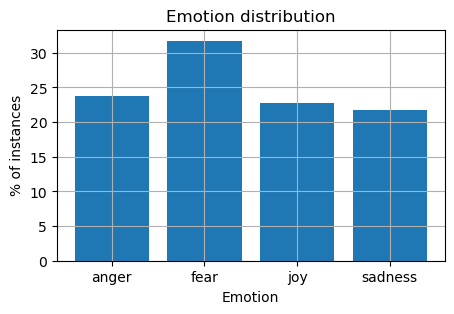

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [14]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

In [15]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

In [16]:
# check the result
train_data_BOW_features

<3613x10115 sparse matrix of type '<class 'numpy.int64'>'
	with 51467 stored elements in Compressed Sparse Row format>

In [17]:
type(train_data_BOW_features)

scipy.sparse._csr.csr_matrix

In [18]:
# add .toarray() to show
train_data_BOW_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
# check the dimension
train_data_BOW_features.shape

(3613, 10115)

In [20]:
# observe some feature names
feature_names = BOW_vectorizer.get_feature_names_out()
feature_names[100:110]

array(['2k17', '2much', '2nd', '30', '300', '301', '30am', '30pm', '30s',
       '31'], dtype=object)

The embedding is done. We can technically feed this into our model. However, depending on the embedding technique you use and your model, your accuracy might not be as high, because:

* curse of dimensionality  (we have 10,115 dimension now)
* some important features are ignored (for example, some models using emoticons yeld better performance than counterparts)

In [21]:
"😂" in feature_names

False

In [22]:
import nltk

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

## check dimension
train_data_BOW_features_500.shape

/Users/jadenliu/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3613, 500)

In [23]:
train_data_BOW_features_500.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0]])

In [24]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()
feature_names_500[100:110]

array(['change', 'cheer', 'cheerful', 'cheerfully', 'cheering', 'cheery',
       'come', 'comes', 'could', 'country'], dtype=object)

In [25]:
"😂" in feature_names_500

True

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)
train_tfidf_counts = vectorizer.fit_transform(train_df.text)
train_tfidf_counts.shape

(3613, 1000)

In [27]:
train_tfidf_counts.toarray()

array([[0.        , 0.11112596, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.48146802, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [28]:
# observe some feature names
feature_names_tfidf = vectorizer.get_feature_names_out()
feature_names_tfidf[100:110]

array(['awful', 'b', 'baby', 'back', 'bad', 'ball', 'balls', 'bb18', 'bc',
       'bday'], dtype=object)

---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habbit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [30]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=0)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['sadness', 'anger', 'anger', 'anger', 'sadness', 'sadness',
       'sadness', 'anger', 'joy', 'fear'], dtype=object)

---
## 4. Results Evaluation

Now we will check the results of our model's performance

In [31]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

training accuracy: 0.99
testing accuracy: 0.66


In [32]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.66      0.69      0.68       110
         joy       0.70      0.68      0.69        79
     sadness       0.65      0.59      0.62        74

    accuracy                           0.66       347
   macro avg       0.66      0.66      0.66       347
weighted avg       0.66      0.66      0.66       347



In [33]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[55 20  5  4]
 [16 76  8 10]
 [ 7  8 54 10]
 [ 9 11 10 44]]


In [34]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

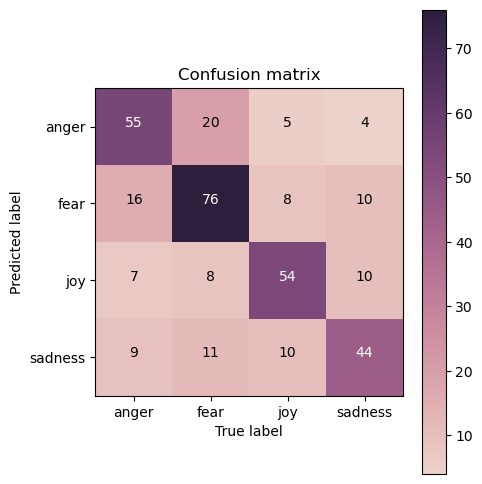

In [35]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

From the above plot we can conclude that our model can predict pretty well because we can see that the true positive of each label is very high compared with the false negative. The true positive here means that when the true label is anger our model also predicted that it is anger, which can be easily seen from the diagonal line which are 55, 76, 54 and 44. Meanwhile the other values are false negative which means that when the true label is anger, our model predicted it as fear/joy/sadness which is wrong.

---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [36]:
from sklearn.naive_bayes import MultinomialNB

## build naive bayes model
NB_model = MultinomialNB()

## training!
NB_model = NB_model.fit(X_train, y_train)

## predict!
y_train_pred = NB_model.predict(X_train)
y_test_pred = NB_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['joy', 'fear', 'anger', 'anger', 'sadness', 'anger', 'anger',
       'sadness', 'anger', 'fear'], dtype='<U7')

In [37]:
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

training accuracy: 0.79
testing accuracy: 0.7
              precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347



In [38]:
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[55 15  5  9]
 [ 9 85  5 11]
 [11  6 56  6]
 [12 10  6 46]]


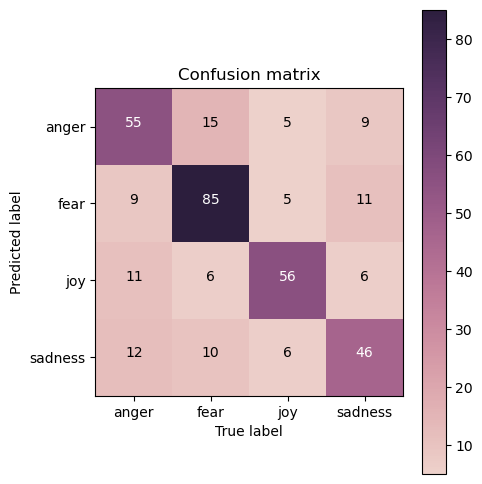

In [39]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

We can see that using the Naive Bayes model can produce a better prediction on the testing data! One thing that might effect these results is that naive bayes ignore irrelevant features and since that we are using a pretty big amount of feature I think that naive bayes can filter out these better, rather than decission tree where we will check each individual feature. 

Meanwhile if we are looking at the accuracy of the training data, we can see that using decission tree we can get such a high accuracy, this is also due to the fact that decission tree model will check each individual feature, hence when predicting on the training data, its no surprise that it would be so high.

## 5. Other things you can try

Thus, there are several things you can try that will affect your results. In order to yield better results, you can experiment by: 
    * Trying different features (Feature engineering)
        -Eg. Word2Vec,PCA,LDA,FastText, Clustering......
    * Trying different models
    * Analyzing your results and interpret them to improve your feature engineering/model building process
    * Iterate through the steps above until finding a satisfying result
Remember that you should also consider the task at hand and the model you'll feed the data to. 

---
## 6. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framwork, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model. Keras runs with Tensorflow in the backend. It's a nice abstraction to start working with NN models. 

Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model.

We will begin by building a fully connected network, which looks like this:

In [40]:
import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


### 6.2 Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves. 

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [41]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.np_utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 1699     fear
764     anger
221     anger
2311      joy
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


### 6.3 Build model

In [42]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


In [43]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                32064     
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
_________________________________________________________________
softmax (Softmax)            (None, 4)                 0     

### 6.4 Train

In [44]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25


/Users/jadenliu/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


 91/113 [=======================>......] - ETA: 0s - loss: 1.3645 - accuracy: 0.3340   

2022-11-22 23:54:09.277481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-22 23:54:09.279295: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


113/113 [==============================] - 7s 2ms/step - loss: 1.3585 - accuracy: 0.3407 - val_loss: 1.2758 - val_accuracy: 0.4352
Epoch 2/25
113/113 [==============================] - 0s 621us/step - loss: 1.0998 - accuracy: 0.6237 - val_loss: 0.9462 - val_accuracy: 0.6513
Epoch 3/25
113/113 [==============================] - 0s 547us/step - loss: 0.6133 - accuracy: 0.7924 - val_loss: 0.7851 - val_accuracy: 0.6974
Epoch 4/25
113/113 [==============================] - 0s 593us/step - loss: 0.4073 - accuracy: 0.8641 - val_loss: 0.8077 - val_accuracy: 0.7032
Epoch 5/25
113/113 [==============================] - 0s 605us/step - loss: 0.3270 - accuracy: 0.8904 - val_loss: 0.8374 - val_accuracy: 0.6772
Epoch 6/25
113/113 [==============================] - 0s 602us/step - loss: 0.2621 - accuracy: 0.9108 - val_loss: 0.9111 - val_accuracy: 0.6916
Epoch 7/25
113/113 [==============================] - 0s 616us/step - loss: 0.2306 - accuracy: 0.9245 - val_loss: 0.9466 - val_accuracy: 0.6945
Epoch

### 6.5 Predict on testing data

In [45]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

array([[1.88713670e-02, 8.16545188e-01, 1.28804848e-01, 3.57785486e-02],
       [7.01249182e-01, 2.71232694e-01, 2.37879958e-02, 3.73015320e-03],
       [6.27899826e-01, 1.62417646e-02, 2.99630756e-08, 3.55858415e-01],
       [9.99891281e-01, 6.71276226e-08, 1.08595035e-04, 1.69773458e-08],
       [6.76325044e-07, 2.42187921e-03, 5.83118981e-06, 9.97571528e-01]],
      dtype=float32)

In [46]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['fear', 'anger', 'anger', 'anger', 'sadness'], dtype=object)

In [47]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.66


In [48]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.376972,1.327769,0.435158,1.275813
1,1,0.656518,0.993131,0.651297,0.946215
2,2,0.792139,0.581771,0.697406,0.785100
3,3,0.846665,0.421750,0.703170,0.807708
4,4,0.876834,0.342814,0.677233,0.837446
5,5,0.903681,0.276620,0.691643,0.911084
6,6,0.922779,0.237135,0.694524,0.946638
7,7,0.935787,0.199508,0.677233,1.002693
8,8,0.946582,0.170450,0.697406,1.067673
9,9,0.952117,0.152976,0.685879,1.121542


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

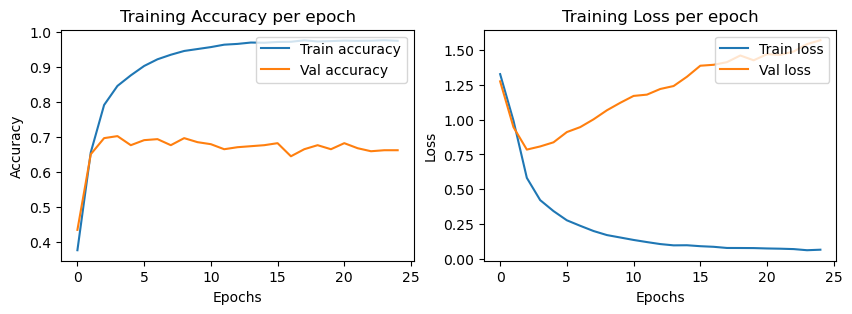

In [49]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(training_log['accuracy'])
ax.plot(training_log['val_accuracy'])
ax.set_title('Training Accuracy per epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend(['Train accuracy', 'Val accuracy'], loc='upper right')

ax2.plot(training_log['loss'])
ax2.plot(training_log['val_loss'])
ax2.set_title('Training Loss per epoch')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Train loss', 'Val loss'], loc='upper right')

plt.show()

By looking at the training loss per epoch graph, we can see that we get a good training loss graph where it starts high and then decreases and flatten near the end of the epoch, which exactlly what we are looking for. But when we see the validation loss, we cann see that at first it starts around 1.25 but as we iterate through the epochs we can see that the validation loss increase and keep on inceasing as the epoch increase, which is a little bad. But based on these observation we can say that it isn't overfitting or underfitting but it isn't that good of a result.

The characteristics of a overfitting graph is that it has gradually decreasing validation loss (without flattening),
and it has very low training loss that’s very slightly increasing upon increase in epochs.

The characterisitcs of an underfitting graph is that it has increasing training loss, and training loss and validation loss are close to each other at the end.

### Note

If you don't have a GPU (level is higher than GTX 1060) or you are not good at setting lots of things about computer, we recommend you to use the [kaggle kernel](https://www.kaggle.com/kernels) to do deep learning model training. They have already installed all the librarys and provided free GPU for you to use.

Note however that you will only be able to run a kernel for 6 hours. After 6 hours of inactivity, your Kaggle kernel will shut down (meaning if your model takes more than 6 hours to train, you can't train it at once).


### More Information for your reference

* Keras document: https://keras.io/
* Keras GitHub example: https://github.com/keras-team/keras/tree/master/examples
* CS229: Machine Learning: http://cs229.stanford.edu/syllabus.html
* Deep Learning cheatsheet: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning
* If you want to try TensorFlow or PyTorch: https://pytorch.org/tutorials/
https://www.tensorflow.org/tutorials/quickstart/beginner

---
## 7. Word2Vector

We will introduce how to use `gensim` to train your word2vec model and how to load a pre-trained model.

https://radimrehurek.com/gensim/index.html

### 7.1 Prepare training corpus

In [50]:
## check library
import gensim

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
1699,20842,"When I walk in darkness of despondency, Sc.ver...","[When, I, walk, in, darkness, of, despondency,..."
764,10764,Don't be bitter,"[Do, n't, be, bitter]"
221,10221,I genuinely think I have anger issues,"[I, genuinely, think, I, have, anger, issues]"
2311,30307,Watch this amazing live.ly broadcast by @paulz...,"[Watch, this, amazing, live.ly, broadcast, by,..."
2500,30496,@smoothkobra after such a heavy 2 days this ha...,"[@, smoothkobra, after, such, a, heavy, 2, day..."


In [51]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['When', 'I', 'walk', 'in', 'darkness', 'of', 'despondency', ',', 'Sc.verses', 'I', "'ve", 'memorized', 'shine', 'a', 'light', 'in', 'my', 'heart', '.', 'Ex', ':', 'Lam', '3:22-25', '#', 'despondency']),
       list(['Do', "n't", 'be', 'bitter']),
       list(['I', 'genuinely', 'think', 'I', 'have', 'anger', 'issues'])],
      dtype=object)

### 7.2 Training our model

You can try to train your own model. More details: https://radimrehurek.com/gensim/models/word2vec.html

In [52]:
from gensim.models import Word2Vec

## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_epochs)

### 7.3 Generating word vector (embeddings)

In [53]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([ 0.3451625 ,  0.7436006 , -0.1831494 ,  0.5768587 , -0.32138297,
       -1.0921985 ,  0.3679505 ,  1.4840857 , -0.38378608, -0.3019597 ,
       -0.344596  , -0.5851259 ,  0.08682026,  0.26713702,  0.03955379,
       -0.47811592,  0.3324728 , -0.5108    ,  0.34537014, -1.3632796 ,
        0.7473516 ,  0.6268982 ,  0.5009725 , -0.15542115,  0.39123514,
       -0.01822153, -0.37107942,  0.4023863 , -0.56706977,  0.15689029,
        0.21084902, -0.05698663,  0.5774991 , -0.45136985,  0.04878693,
        0.6777543 , -0.01687848, -0.12674275, -0.6054686 , -0.0586169 ,
        0.1328236 , -0.04022205, -0.18951704,  0.19784915,  0.5299605 ,
       -0.33310896, -0.8013077 ,  0.3331618 ,  0.23672207,  0.2896777 ,
       -0.23293424, -0.4196928 , -0.45731822, -0.02433025, -0.84575295,
       -0.01073073, -0.05815085, -0.4103811 , -0.00918995,  0.25092244,
        0.384511  , -0.5797727 ,  0.61399734,  0.26054654, -0.92786217,
        0.7680666 ,  0.0581701 ,  0.628474  , -1.6039342 ,  0.74

In [54]:
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[('Makes', 0.9362680912017822),
 ('free', 0.9192560315132141),
 ('Be', 0.9179859757423401),
 ('kinda', 0.9131149649620056),
 ('dad', 0.9115126132965088),
 ('right', 0.9088760614395142),
 ('.\\nA', 0.9083594083786011),
 ('birthday', 0.9077358245849609),
 ('help', 0.9076694250106812),
 ('yet', 0.9066837430000305)]

### 7.4 Using a pre-trained w2v model

Instead of training your own model ,you can use a model that has already been trained. Here, we see 2 ways of doing that:


#### (1) Download model by yourself

source: [GoogleNews-vectors-negative300](https://code.google.com/archive/p/word2vec/)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [55]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "GoogleNews/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

#### (2) Using gensim api

Other pretrained models are available here: https://github.com/RaRe-Technologies/gensim-data

In [56]:
import gensim.downloader as api

## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.9336148500442505),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678),
 ('hello', 0.9158350825309753),
 ('thanks', 0.9150084853172302),
 ('merry', 0.9053248763084412),
 ('bless', 0.902732253074646),
 ('wish', 0.9013165235519409)]

### 7.5 king + woman - man = ?

Let's run one of the most famous examples for Word2Vec and compute the similarity between these 3 words:

In [57]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411403656006)]

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


One way that we can incoporate these "word" vectors to be used inside our model is that we might add 4 new features into our training data where we first get the top 10 most similar words of anger, fear, joy and sadness. Next we will compare and see whether our text contains these 10 most similar words for each label or not, if it exists then we will give it a value of how many of the top 10 most similar words are present in that current text, if it doesn't exist then we will give it a value of 0. By doing so I think that it might be an important feature that can help the model to tell whether that text should be classified as anger/fear/joy/sadness.

### 8. Clustering: k-means

Here we introduce how to use `sklearn` to do the basic **unsupervised learning** approach, k-means.    

more details: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


#### Basic concept

![Image](https://i.imgur.com/PEdUf54.png)

(img source: https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d)

In [58]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']


In [59]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

word: happy 	 cluster: 0
word: fear 	 cluster: 0
word: angry 	 cluster: 0
word: car 	 cluster: 1
word: teacher 	 cluster: 1
word: computer 	 cluster: 1


![Imgur](pics/pic6.png)

In [60]:
#check cluster membership
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1], dtype=int32)

In [61]:
#check cluster membership
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0], dtype=int32)


## 9. High-dimension Visualization: t-SNE

No matter if you use the Bag-of-words, TF-IDF, or Word2Vec, it's very hard to see the embedding result, because the dimension is larger than 3.  

In Lab 1, we already talked about PCA. We can use PCA to reduce the dimension of our data, then visualize it. However, if you dig deeper into the result, you'd find it is insufficient.

Our aim will be to create a visualization similar to the one below:

![Image](pics/pic7.png)
source: https://www.fabian-keller.de/research/high-dimensional-data-visualization 

Here we would like to introduce another visualization method called t-SNE.  
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html 

### 9.1 Prepare visualizing target

Let's prepare data lists like:
- happy words
- angry words
- data words
- mining words

In [62]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


### 9.2 Plot using t-SNE (2-dimension)

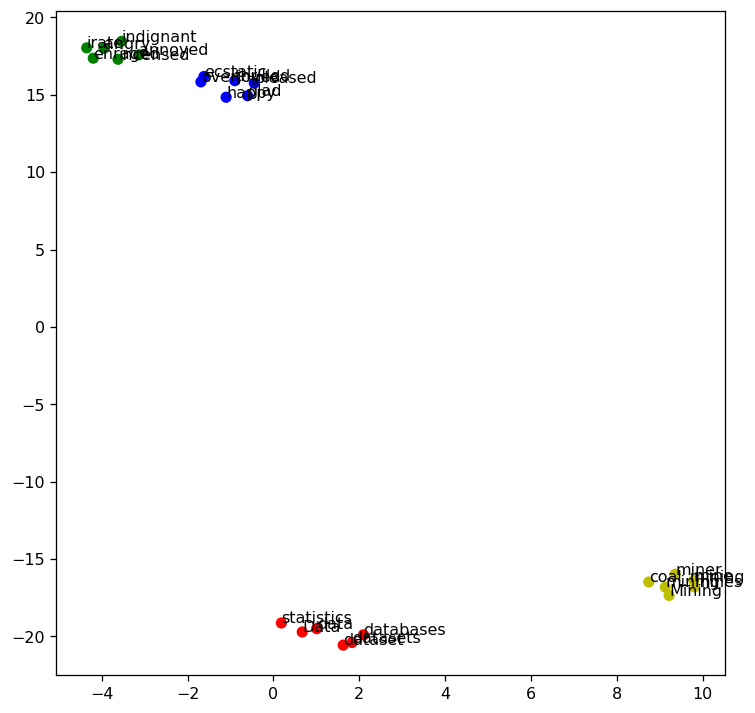

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [64]:
word_list = ['angry', 'happy', 'sad', 'fear']

topn = 15
angry_words = [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
happy_words = [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]        
sad_words = [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]        
fear_words = [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]        

print('angry_words: ', angry_words)
print('happy_words: ', happy_words)
print('sad_words: ', sad_words)
print('fear_words: ', fear_words)

target_words = angry_words + happy_words + sad_words + fear_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

angry_words:  ['irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
happy_words:  ['glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
sad_words:  ['saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet']
fear_words:  ['fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

target words: 
['irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry', 'glad', '

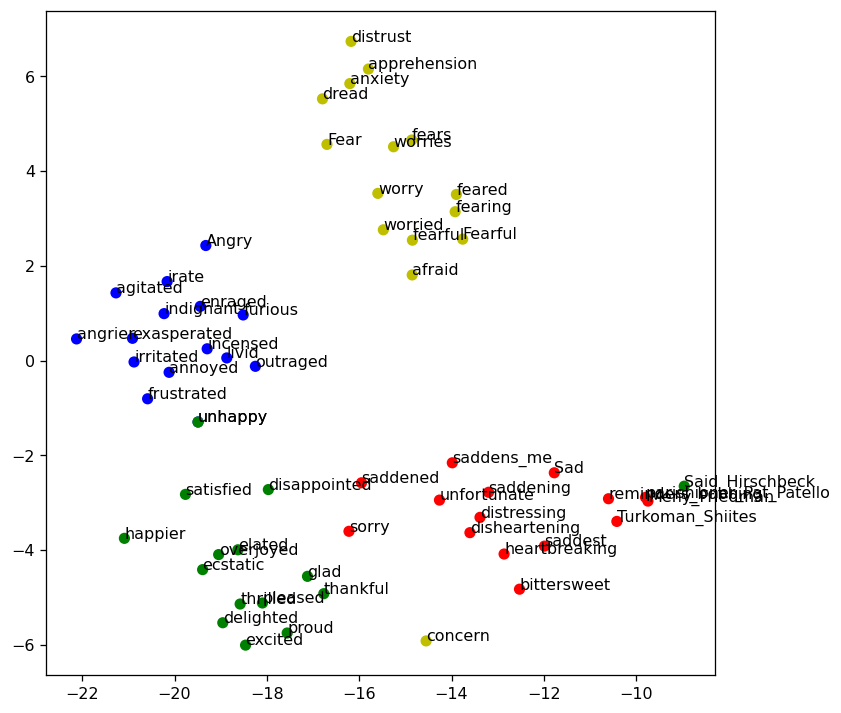

In [65]:
## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

# Part 2 (Kaggle Competition)

### Load and Prepare Data

In [66]:
# load data
import json
import pandas as pd

data_identification = pd.read_csv("data/data_identification.csv")
emotion = pd.read_csv("data/emotion.csv")
tweets = [json.loads(line) for line in open("data/tweets_DM.json", 'r', encoding='utf-8')]

In [67]:
print(data_identification.shape)
data_identification.head()

(1867535, 2)


,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train


In [68]:
print(emotion.shape)
emotion.head()

(1455563, 2)


,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


In [69]:
print(len(tweets))
tweets[0]

1867535


{'_score': 391,
 '_index': 'hashtag_tweets',
 '_source': {'tweet': {'hashtags': ['Snapchat'],
   'tweet_id': '0x376b20',
   'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}},
 '_crawldate': '2015-05-23 11:42:47',
 '_type': 'tweets'}

In [70]:
# split training and testing data
train_df = data_identification[data_identification['identification'] == 'train']
test_df = data_identification[data_identification['identification'] == 'test']

print("Training data shape: ", train_df.shape)
print("Testing data shape: ", test_df.shape)

Training data shape:  (1455563, 2)
Testing data shape:  (411972, 2)


In [71]:
# concat emotion to train data based on tweet_id
train_df = pd.merge(train_df, emotion, on='tweet_id')
train_df

,tweet_id,identification,emotion
0,0x29e452,train,joy
1,0x2b3819,train,joy
2,0x2a2acc,train,trust
3,0x2a8830,train,joy
4,0x20b21d,train,anticipation
...,...,...,...
1455558,0x227e25,train,disgust
1455559,0x293813,train,sadness
1455560,0x1e1a7e,train,joy
1455561,0x2156a5,train,trust


In [72]:
def get_source(obj):
    return obj['_source']['tweet']

tweets_text = list(map(get_source, tweets))
tweets_text[0]

{'hashtags': ['Snapchat'],
 'tweet_id': '0x376b20',
 'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}

In [73]:
# create dataframe from tweets text
tweets_df = pd.DataFrame.from_dict(tweets_text)
tweets_df

,hashtags,tweet_id,text
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,[],0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...,...
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...
1867532,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,[],0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [74]:
# concat tweets to train data based on tweet_id
train_df = pd.merge(train_df, tweets_df, on='tweet_id')
train_df

,tweet_id,identification,emotion,hashtags,text
0,0x29e452,train,joy,[],Huge Respect🖒 @JohnnyVegasReal talking about l...
1,0x2b3819,train,joy,"[spateradio, app]",Yoooo we hit all our monthly goals with the ne...
2,0x2a2acc,train,trust,[],@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",Come join @ambushman27 on #PUBG while he striv...
4,0x20b21d,train,anticipation,"[strength, bones, God]",@fanshixieen2014 Blessings!My #strength little...
...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],@BBCBreaking Such an inspirational talented pe...
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]",And still #libtards won't get off the guy's ba...
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]",When you sow #seeds of service or hospitality ...
1455561,0x2156a5,train,trust,[],@lorettalrose Will you be displaying some <LH>...


In [75]:
# concat tweets to test data based on tweet_id
test_df = pd.merge(test_df, tweets_df, on='tweet_id')
test_df

,tweet_id,identification,hashtags,text
0,0x28cc61,test,[],@Habbo I've seen two separate colours of the e...
1,0x2db41f,test,[],@FoxNews @KellyannePolls No serious self respe...
2,0x2466f6,test,[womendrivers],"Looking for a new car, and it says 1 lady owne..."
3,0x23f9e9,test,[robbingmembers],@cineworld “only the brave” just out and fount...
4,0x1fb4e1,test,[],Felt like total dog 💩 going into open gym and ...
...,...,...,...,...
411967,0x2c4dc2,test,[kids],6 year old walks in astounded. Mum! Look how b...
411968,0x31be7c,test,[inspiringvolunteerawards2017],Only one week to go until the #inspiringvolunt...
411969,0x1ca58e,test,[],"I just got caught up with the manga for ""My He..."
411970,0x35c8ba,test,[],Speak only when spoken to and make hot ass mus...


### Data Exploration + Feature Engineering

In [76]:
train_df

,tweet_id,identification,emotion,hashtags,text
0,0x29e452,train,joy,[],Huge Respect🖒 @JohnnyVegasReal talking about l...
1,0x2b3819,train,joy,"[spateradio, app]",Yoooo we hit all our monthly goals with the ne...
2,0x2a2acc,train,trust,[],@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",Come join @ambushman27 on #PUBG while he striv...
4,0x20b21d,train,anticipation,"[strength, bones, God]",@fanshixieen2014 Blessings!My #strength little...
...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],@BBCBreaking Such an inspirational talented pe...
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]",And still #libtards won't get off the guy's ba...
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]",When you sow #seeds of service or hospitality ...
1455561,0x2156a5,train,trust,[],@lorettalrose Will you be displaying some <LH>...


In [77]:
# get total number of output labels
train_df['emotion'].value_counts()

joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: emotion, dtype: int64

<AxesSubplot:>

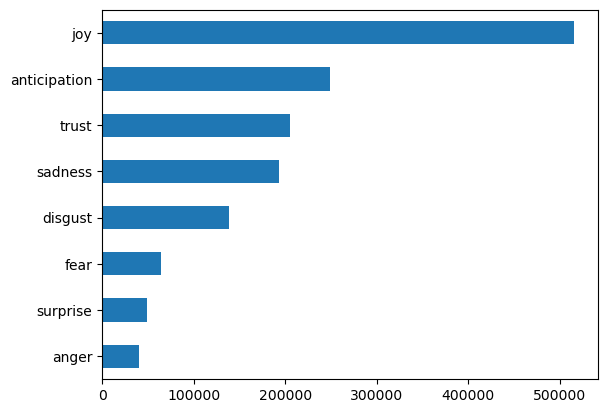

In [78]:
# plot bar graph of emotion distribution
train_df['emotion'].value_counts().sort_values().plot(kind = 'barh')

In [79]:
# get top 100 most similar word with each class
topn = 100

joy_words = [word_ for word_, sim_ in w2v_google_model.most_similar('joy', topn=topn)]
anticipation_words = [word_ for word_, sim_ in w2v_google_model.most_similar('anticipation', topn=topn)]        
trust_words = [word_ for word_, sim_ in w2v_google_model.most_similar('trust', topn=topn)]        
sadness_words = [word_ for word_, sim_ in w2v_google_model.most_similar('sadness', topn=topn)]
disgust_words = [word_ for word_, sim_ in w2v_google_model.most_similar('disgust', topn=topn)]
fear_words = [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]        
surprise_words = [word_ for word_, sim_ in w2v_google_model.most_similar('surprise', topn=topn)]        
anger_words = [word_ for word_, sim_ in w2v_google_model.most_similar('anger', topn=topn)]

print('joy_words: ', joy_words)
print('\n')
print('anticipation_words: ', anticipation_words)
print('\n')
print('trust_words: ', trust_words)
print('\n')
print('sadness_words: ', sadness_words)
print('\n')
print('disgust_words: ', disgust_words)
print('\n')
print('fear_words: ', fear_words)
print('\n')
print('surprise_words: ', surprise_words)
print('\n')
print('anger_words: ', anger_words)

joy_words:  ['sheer_joy', 'exhilaration', 'elation', 'unbridled_joy', 'joyful', 'delight', 'excitement', 'joyousness', 'thrill', 'happiness', 'indescribable_joy', 'joyous', 'jubilation', 'pleasure', 'sadness', 'joys', 'contentment', 'gladness', 'sorrow', 'unconfined_joy', 'thankfulness', 'joyanta.acharjee_@_thomson.com', 'despair', 'anguish', 'unadulterated_joy', 'wonderment', 'rejoicing', 'passion', 'glee', 'heartache', 'exultation', 'radiated_warmth', 'joyously', 'jubilance', 'unbounded_joy', 'pride', 'enthusiasm', 'agony', 'heartbreak', 'joyfully', 'mirth', 'amazement', 'love', 'joyfulness', 'exuberance', 'excitment', 'emotion', 'pure_elation', 'Atanie_freshly_bathed', 'longing', 'enjoyment', 'Besnik_Berisha_Pristina', 'newsdesk@afxnews.com_joy', 'pure_unadulterated_joy', 'laughter', 'inconsolable_grief', 'gratefulness', 'Happy_Meal_derided', 'zest', 'Kate_Middleton_bubbled', 'pure_bliss', 'Hugs_kisses', 'hapiness', 'grief', 'vivaciousness', 'mourning_Roopan', 'fatherly_pride', 'she

In [80]:
# convert all text to lower case
train_df['text']=train_df['text'].str.lower()
train_df

,tweet_id,identification,emotion,hashtags,text
0,0x29e452,train,joy,[],huge respect🖒 @johnnyvegasreal talking about l...
1,0x2b3819,train,joy,"[spateradio, app]",yoooo we hit all our monthly goals with the ne...
2,0x2a2acc,train,trust,[],@kidsnts @picu_bch @uhbcomms @bwchboss well do...
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join @ambushman27 on #pubg while he striv...
4,0x20b21d,train,anticipation,"[strength, bones, God]",@fanshixieen2014 blessings!my #strength little...
...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],@bbcbreaking such an inspirational talented pe...
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]",and still #libtards won't get off the guy's ba...
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]",when you sow #seeds of service or hospitality ...
1455561,0x2156a5,train,trust,[],@lorettalrose will you be displaying some <lh>...


In [81]:
# remove stop words from text
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

train_df['text'] = train_df['text'].apply(lambda text: remove_stopwords(text))
train_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jadenliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_id,identification,emotion,hashtags,text
0,0x29e452,train,joy,[],huge respect🖒 @johnnyvegasreal talking losing ...
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. #sp...
2,0x2a2acc,train,trust,[],@kidsnts @picu_bch @uhbcomms @bwchboss well do...
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join @ambushman27 #pubg strives chicken d...
4,0x20b21d,train,anticipation,"[strength, bones, God]",@fanshixieen2014 blessings!my #strength little...
...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"@bbcbreaking inspirational talented person, mi..."
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still #libtards get guy's back, #hillary #lost..."
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow #seeds service hospitality #joy, earth yie..."
1455561,0x2156a5,train,trust,[],@lorettalrose displaying <lh> wares @lorettalrose


In [82]:
# remove all mentions (words starting with @)
def remove_metions(text):
    return " ".join(filter(lambda x:x[0]!='@', text.split()))

train_df['text'] = train_df['text'].apply(lambda text: remove_metions(text))
train_df

,tweet_id,identification,emotion,hashtags,text
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do..."
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. #sp...
2,0x2a2acc,train,trust,[],well done team 🌟 <lh> every one you.
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join #pubg strives chicken donners! #game...
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my #strength little. #bones brittle....
...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss #rip <lh>"
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still #libtards get guy's back, #hillary #lost..."
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow #seeds service hospitality #joy, earth yie..."
1455561,0x2156a5,train,trust,[],displaying <lh> wares


In [83]:
# remove hashtags from text
def remove_hashtags(text):
    return text.replace("#", "") 

train_df['text'] = train_df['text'].apply(lambda text: remove_hashtags(text))
train_df

,tweet_id,identification,emotion,hashtags,text
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do..."
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...
2,0x2a2acc,train,trust,[],well done team 🌟 <lh> every one you.
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...
...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>"
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f..."
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield..."
1455561,0x2156a5,train,trust,[],displaying <lh> wares


In [84]:
# remove urls from text
import re

def remove_url(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)

train_df['text'] = train_df['text'].apply(lambda x: remove_url(x))
train_df

,tweet_id,identification,emotion,hashtags,text
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do..."
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...
2,0x2a2acc,train,trust,[],well done team 🌟 <lh> every one you.
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...
...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>"
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f..."
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield..."
1455561,0x2156a5,train,trust,[],displaying <lh> wares


In [85]:
# turn emoji into words
import emoji

def convert_emojis(text):
    return emoji.demojize(text)

train_df['text'] = train_df['text'].apply(lambda x: convert_emojis(x))
train_df

,tweet_id,identification,emotion,hashtags,text
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do..."
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...
...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>"
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f..."
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield..."
1455561,0x2156a5,train,trust,[],displaying <lh> wares


In [86]:
# get number of occurance of top joy words in text
def count_joy_top_words(text):
    total = 0
    for word in joy_words:
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text))
        total = total + count
    
    return total

train_df['top_joy_words'] = train_df['text'].apply(lambda x: count_joy_top_words(x))
train_df

,tweet_id,identification,emotion,hashtags,text,top_joy_words
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do...",0
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...,0
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.,0
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...,0
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...,0
...,...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>",0
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f...",0
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield...",0
1455561,0x2156a5,train,trust,[],displaying <lh> wares,0


In [87]:
# get number of occurance of top anticipation words in text
def count_anticipation_top_words(text):
    total = 0
    for word in anticipation_words:
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text))
        total = total + count
    
    return total

train_df['top_anticipation_words'] = train_df['text'].apply(lambda x: count_anticipation_top_words(x))
train_df

,tweet_id,identification,emotion,hashtags,text,top_joy_words,top_anticipation_words
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do...",0,0
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...,0,0
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.,0,0
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...,0,0
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...,0,0
...,...,...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>",0,0
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f...",0,0
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield...",0,0
1455561,0x2156a5,train,trust,[],displaying <lh> wares,0,0


In [88]:
# get number of occurance of top trust words in text
def count_trust_top_words(text):
    total = 0
    for word in trust_words:
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text))
        total = total + count
    
    return total

train_df['top_trust_words'] = train_df['text'].apply(lambda x: count_trust_top_words(x))
train_df

,tweet_id,identification,emotion,hashtags,text,top_joy_words,top_anticipation_words,top_trust_words
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do...",0,0,1
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...,0,0,0
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.,0,0,0
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...,0,0,0
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...,0,0,0
...,...,...,...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>",0,0,0
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f...",0,0,0
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield...",0,0,0
1455561,0x2156a5,train,trust,[],displaying <lh> wares,0,0,0


In [89]:
# get number of occurance of top sadness words in text
def count_sadness_top_words(text):
    total = 0
    for word in sadness_words:
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text))
        total = total + count
    
    return total

train_df['top_sadness_words'] = train_df['text'].apply(lambda x: count_sadness_top_words(x))
train_df

,tweet_id,identification,emotion,hashtags,text,top_joy_words,top_anticipation_words,top_trust_words,top_sadness_words
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do...",0,0,1,0
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...,0,0,0,0
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.,0,0,0,0
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...,0,0,0,0
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>",0,0,0,0
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f...",0,0,0,1
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield...",0,0,0,1
1455561,0x2156a5,train,trust,[],displaying <lh> wares,0,0,0,0


In [90]:
# get number of occurance of top disgust words in text
def count_disgust_top_words(text):
    total = 0
    for word in disgust_words:
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text))
        total = total + count
    
    return total

train_df['top_disgust_words'] = train_df['text'].apply(lambda x: count_disgust_top_words(x))
train_df

,tweet_id,identification,emotion,hashtags,text,top_joy_words,top_anticipation_words,top_trust_words,top_sadness_words,top_disgust_words
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do...",0,0,1,0,0
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...,0,0,0,0,0
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.,0,0,0,0,0
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...,0,0,0,0,0
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>",0,0,0,0,0
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f...",0,0,0,1,0
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield...",0,0,0,1,0
1455561,0x2156a5,train,trust,[],displaying <lh> wares,0,0,0,0,0


In [91]:
# get number of occurance of top fear words in text
def count_fear_top_words(text):
    total = 0
    for word in fear_words:
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text))
        total = total + count
    
    return total

train_df['top_fear_words'] = train_df['text'].apply(lambda x: count_fear_top_words(x))
train_df

,tweet_id,identification,emotion,hashtags,text,top_joy_words,top_anticipation_words,top_trust_words,top_sadness_words,top_disgust_words,top_fear_words
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do...",0,0,1,0,0,0
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...,0,0,0,0,0,0
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.,0,0,0,0,0,0
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...,0,0,0,0,0,0
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>",0,0,0,0,0,0
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f...",0,0,0,1,0,0
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield...",0,0,0,1,0,0
1455561,0x2156a5,train,trust,[],displaying <lh> wares,0,0,0,0,0,0


In [92]:
# get number of occurance of top surprise words in text
def count_surprise_top_words(text):
    total = 0
    for word in surprise_words:
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text))
        total = total + count
    
    return total

train_df['top_surprise_words'] = train_df['text'].apply(lambda x: count_surprise_top_words(x))
train_df

,tweet_id,identification,emotion,hashtags,text,top_joy_words,top_anticipation_words,top_trust_words,top_sadness_words,top_disgust_words,top_fear_words,top_surprise_words
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do...",0,0,1,0,0,0,0
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...,0,0,0,0,0,0,0
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.,0,0,0,0,0,0,0
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...,0,0,0,0,0,0,0
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>",0,0,0,0,0,0,0
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f...",0,0,0,1,0,0,0
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield...",0,0,0,1,0,0,0
1455561,0x2156a5,train,trust,[],displaying <lh> wares,0,0,0,0,0,0,0


In [93]:
# get number of occurance of top anger words in text
def count_anger_top_words(text):
    total = 0
    for word in anger_words:
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text))
        total = total + count
    
    return total

train_df['top_anger_words'] = train_df['text'].apply(lambda x: count_anger_top_words(x))
train_df

,tweet_id,identification,emotion,hashtags,text,top_joy_words,top_anticipation_words,top_trust_words,top_sadness_words,top_disgust_words,top_fear_words,top_surprise_words,top_anger_words
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do...",0,0,1,0,0,0,0,0
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...,0,0,0,0,0,0,0,0
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.,0,0,0,0,0,0,0,0
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...,0,0,0,0,0,0,0,0
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>",0,0,0,0,0,0,0,0
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f...",0,0,0,1,0,0,0,0
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield...",0,0,0,1,0,0,0,0
1455561,0x2156a5,train,trust,[],displaying <lh> wares,0,0,0,0,0,0,0,0


### Model

In [94]:
emotion_mapping  = {
    "joy":0, 
    "anticipation":1,
    "trust":2,
    "sadness":3,
    "disgust":4,
    "fear":5,
    "surprise":6,
    "anger":7,
}

In [95]:
train_df["emotion_id"] = train_df['emotion'].map(emotion_mapping)
train_df

,tweet_id,identification,emotion,hashtags,text,top_joy_words,top_anticipation_words,top_trust_words,top_sadness_words,top_disgust_words,top_fear_words,top_surprise_words,top_anger_words,emotion_id
0,0x29e452,train,joy,[],"huge respect🖒 talking losing dad cancer.""if do...",0,0,1,0,0,0,0,0,0
1,0x2b3819,train,joy,"[spateradio, app]",yoooo hit monthly goals new app two weeks. spa...,0,0,0,0,0,0,0,0,0
2,0x2a2acc,train,trust,[],well done team :glowing_star: <lh> every one you.,0,0,0,0,0,0,0,0,2
3,0x2a8830,train,joy,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",come join pubg strives chicken donners! gamers...,0,0,0,0,0,0,0,0,0
4,0x20b21d,train,anticipation,"[strength, bones, God]",blessings!my strength little. bones brittle.do...,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455558,0x227e25,train,disgust,[rip],"inspirational talented person, miss rip <lh>",0,0,0,0,0,0,0,0,4
1455559,0x293813,train,sadness,"[libtards, Hillary, lost, sad, growup, Trump]","still libtards get guy's back, hillary lost. f...",0,0,0,1,0,0,0,0,3
1455560,0x1e1a7e,train,joy,"[seeds, Joy, GLTChurch]","sow seeds service hospitality joy, earth yield...",0,0,0,1,0,0,0,0,0
1455561,0x2156a5,train,trust,[],displaying <lh> wares,0,0,0,0,0,0,0,0,2


In [96]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jadenliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
# apply all functions to testing data
test_df['text']=test_df['text'].str.lower()
test_df['text'] = test_df['text'].apply(lambda text: remove_stopwords(text))
test_df['text'] = test_df['text'].apply(lambda text: remove_metions(text))
test_df['text'] = test_df['text'].apply(lambda x: remove_url(x))
test_df['text'] = test_df['text'].apply(lambda x: convert_emojis(x))
test_df['top_joy_words'] = test_df['text'].apply(lambda x: count_joy_top_words(x))
test_df['top_anticipation_words'] = test_df['text'].apply(lambda x: count_anticipation_top_words(x))
test_df['top_trust_words'] = test_df['text'].apply(lambda x: count_trust_top_words(x))
test_df['top_sadness_words'] = test_df['text'].apply(lambda x: count_sadness_top_words(x))
test_df['top_disgust_words'] = test_df['text'].apply(lambda x: count_disgust_top_words(x))
test_df['top_fear_words'] = test_df['text'].apply(lambda x: count_fear_top_words(x))
test_df['top_surprise_words'] = test_df['text'].apply(lambda x: count_surprise_top_words(x))
test_df['top_anger_words'] = test_df['text'].apply(lambda x: count_anger_top_words(x))

In [98]:
test_df

,tweet_id,identification,hashtags,text,top_joy_words,top_anticipation_words,top_trust_words,top_sadness_words,top_disgust_words,top_fear_words,top_surprise_words,top_anger_words
0,0x28cc61,test,[],i've seen two separate colours elegant furni h...,0,0,0,0,0,0,0,0
1,0x2db41f,test,[],serious self respecting individual believes mu...,0,0,0,0,0,0,0,0
2,0x2466f6,test,[womendrivers],"looking new car, says 1 lady owner. means need...",0,0,0,0,0,0,0,0
3,0x23f9e9,test,[robbingmembers],“only brave” fountain park 3 showings per day!...,0,0,0,0,0,0,0,0
4,0x1fb4e1,test,[],felt like total dog :pile_of_poo: going open g...,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
411967,0x2c4dc2,test,[kids],6 year old walks astounded. mum! look bendy am...,0,0,0,0,0,0,1,0
411968,0x31be7c,test,[inspiringvolunteerawards2017],one week go #inspiringvolunteerawards2017 cant...,0,0,0,0,0,0,0,0
411969,0x1ca58e,test,[],"got caught manga ""my hero academia"", know next...",0,0,0,0,0,0,0,0
411970,0x35c8ba,test,[],speak spoken make hot ass music <lh>,0,0,0,0,0,0,0,0


In [99]:
# Calculate all article TF-IDF weight
from sklearn.feature_extraction.text import TfidfVectorizer

all_articles = train_df['text']
all_articles = all_articles.append(test_df['text'])

tfidf_vect = TfidfVectorizer(tokenizer=tokenizer_stem_nostop)
article_tfidf_count = tfidf_vect.fit_transform(all_articles)

In [100]:
article_tfidf_count.shape

(1867535, 879467)

In [101]:
# Split into training and testing
train_tfidf = article_tfidf_count[:1455563, :]
test_tfidf = article_tfidf_count[1455563:, :]

In [102]:
print("Training dataframe shape: ", train_tfidf.shape)
print("Testing dataframe shape: ", test_tfidf.shape)

Training dataframe shape:  (1455563, 879467)
Testing dataframe shape:  (411972, 879467)


In [103]:
# Concatenate tf_idf matrix with new features
from scipy.sparse import hstack

train_tfidf = hstack((
    train_tfidf, 
    train_df['top_joy_words'][:,None], 
    train_df['top_anticipation_words'][:,None], 
    train_df['top_trust_words'][:,None],
    train_df['top_sadness_words'][:,None],
    train_df['top_disgust_words'][:,None],
    train_df['top_fear_words'][:,None],
    train_df['top_surprise_words'][:,None],
    train_df['top_anger_words'][:,None],
))

train_tfidf.shape

(1455563, 879475)

In [104]:
# Split into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_tfidf, train_df['emotion_id'], test_size=0.2)

In [105]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

### Experiments

We are going to try different kinds of models to figure out which one would yield the best results

### 1) Logistic Regression Model

In [106]:
# Implement model
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(penalty='l2', max_iter=500, multi_class='ovr', solver='liblinear')

In [107]:
# fit training data and predict testing data
LR_model.fit(X_train, Y_train)

y_pred = LR_model.predict(X_val)
y_pred

array([2, 0, 2, ..., 0, 0, 6])

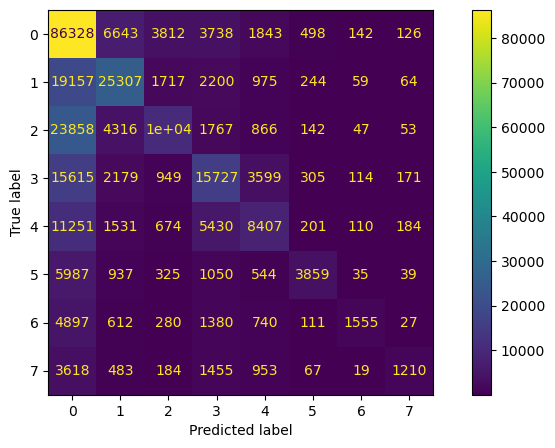

In [108]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred, ax=ax)

In [109]:
roc_auc_dict = roc_auc_score_multiclass(Y_val, y_pred)
roc_auc_dict

{0: 0.6940965394324607,
 1: 0.7198864216146366,
 2: 0.6095250850680903,
 3: 0.6696975985882488,
 4: 0.6331938111087281,
 5: 0.6482086306896424,
 6: 0.5800384698853568,
 7: 0.5745564964770712}

### 2) Multi-class Decision Tree

In [110]:
from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier(random_state=0)

In [111]:
# fit training data and predict testing data
DT_model.fit(X_train, Y_train)

y_pred = DT_model.predict(X_val)
y_pred

array([2, 0, 4, ..., 0, 0, 6])

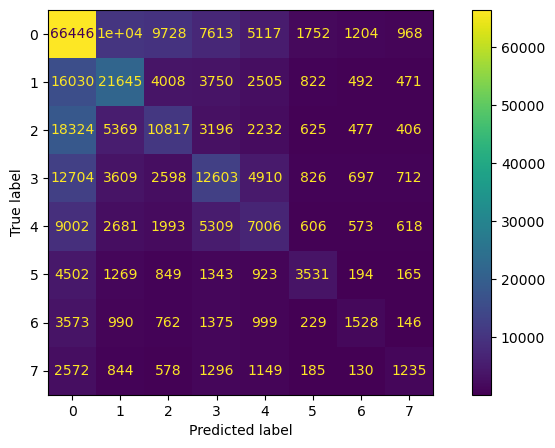

In [112]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred, ax=ax)

In [113]:
roc_auc_dict = roc_auc_score_multiclass(Y_val, y_pred)
roc_auc_dict

{0: 0.6447185269144177,
 1: 0.6657398266274193,
 2: 0.5894083745394545,
 3: 0.6157024408923489,
 4: 0.5921966136000545,
 5: 0.6291260366221205,
 6: 0.572876076987734,
 7: 0.57113746581117}

### 3) Multi-class Random Forest

In [114]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(max_depth=8, random_state=0)

In [115]:
# fit training data and predict testing data
RF_model.fit(X_train, Y_train)

y_pred = RF_model.predict(X_val)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

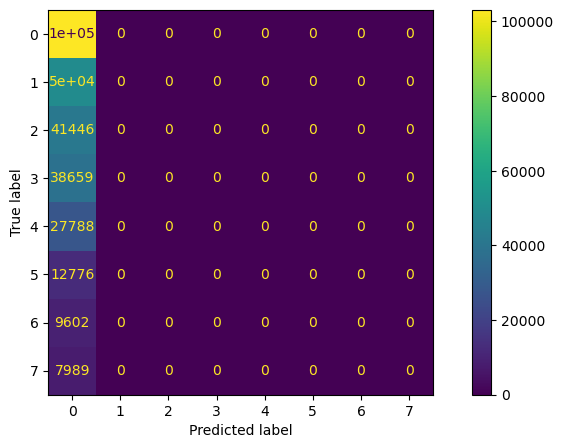

In [116]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred, ax=ax)

In [117]:
roc_auc_dict = roc_auc_score_multiclass(Y_val, y_pred)
roc_auc_dict

{0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5, 6: 0.5, 7: 0.5}

### 4) Naive-Bayes Model

In [118]:
from sklearn.naive_bayes import MultinomialNB

NB_model = MultinomialNB()

In [119]:
# fit training data and predict testing data
NB_model.fit(X_train, Y_train)

y_pred = NB_model.predict(X_val)
y_pred

array([0, 0, 0, ..., 0, 0, 6])

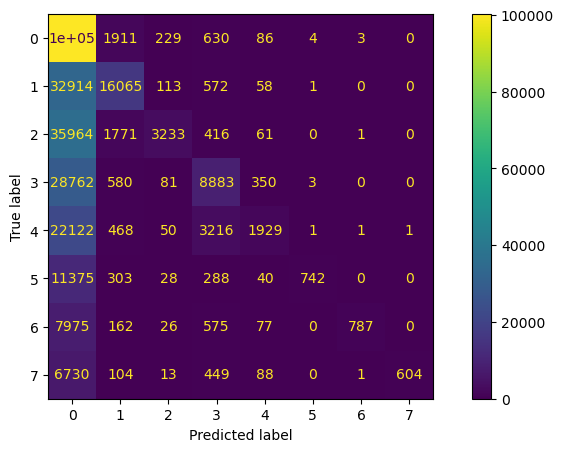

In [120]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred, ax=ax)

In [121]:
roc_auc_dict = roc_auc_score_multiclass(Y_val, y_pred)
roc_auc_dict

{0: 0.5982067240845954,
 1: 0.6505689451538823,
 2: 0.5379211170660394,
 3: 0.6027166444606806,
 4: 0.5332661433625749,
 5: 0.5290226553410502,
 6: 0.5409703888383194,
 7: 0.5378002117087116}

### 5) KNN Model

In [122]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(n_neighbors=8)

In [123]:
# fit training data and predict testing data
KNN_model.fit(X_train, Y_train)

y_pred = KNN_model.predict(X_val)
y_pred

array([1, 0, 0, ..., 0, 0, 6])

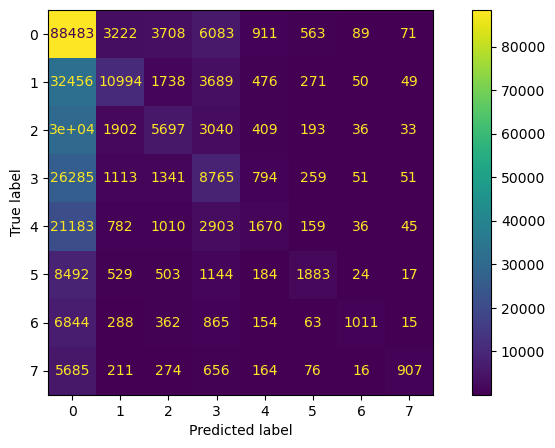

In [124]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred, ax=ax)

In [125]:
roc_auc_dict = roc_auc_score_multiclass(Y_val, y_pred)
roc_auc_dict

{0: 0.5803364776235702,
 1: 0.5938844130740069,
 2: 0.5508321461448629,
 3: 0.5769603230090621,
 4: 0.524177870119985,
 5: 0.5708473901187464,
 6: 0.5521088911149367,
 7: 0.556269303641499}

### 6) Support Vector Machine Model

In [126]:
from sklearn.svm import LinearSVC

SVM_model = LinearSVC(max_iter=3000)

In [127]:
# fit training data and predict testing data
SVM_model.fit(X_train, Y_train)

y_pred = SVM_model.predict(X_val)
y_pred

array([2, 0, 1, ..., 0, 3, 6])

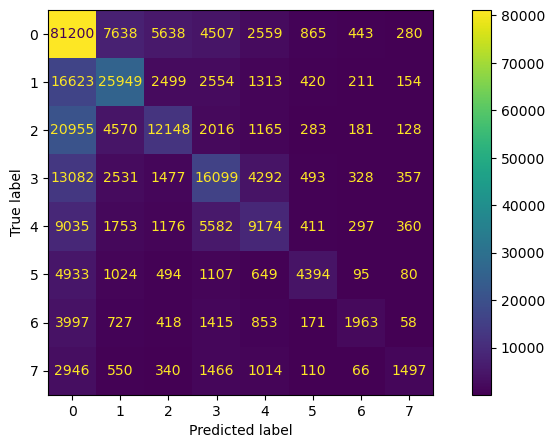

In [128]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred, ax=ax)

In [129]:
roc_auc_dict = roc_auc_score_multiclass(Y_val, y_pred)
roc_auc_dict

{0: 0.7033122641168952,
 1: 0.7220089498814443,
 2: 0.6224360174587469,
 3: 0.6712865281565507,
 4: 0.642580035702088,
 5: 0.6670176118970164,
 6: 0.5993391818892565,
 7: 0.5911888884779618}

### 7) CNN Model + Word Embedding

In [140]:
# prepare data for CNN Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

X = train_df['text']
Y = train_df['emotion_id']

tokenizer = Tokenizer(nb_words=20000)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
X_processed = pad_sequences(sequences, maxlen=1000)

In [141]:
# split training data
X_train, X_val, Y_train, Y_val = train_test_split(X_processed, Y, test_size=0.2)

In [132]:
# get word embedding from downloaded glove
embeddings = {}
with open('glove.twitter.27B/glove.twitter.27B.200d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs

In [133]:
# create embedding layer
from keras.layers import Embedding

nb_words = min(20000, len(word_index))
embedding_matrix = np.zeros((nb_words, 200))

for word, i in word_index.items():
    if i >= 20000:
        continue
        
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(nb_words, 200, weights=[embedding_matrix], input_length=1000, trainable=False)

In [134]:
# create CNN model
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv1D, MaxPooling1D, AveragePooling1D

model = Sequential([
    embedding_layer,
    Conv1D(512, 5, activation='relu'),
    AveragePooling1D(5),
    Conv1D(256, 5, activation='relu'),
    AveragePooling1D(5),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         4000000   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 996, 512)          512512    
_________________________________________________________________
average_pooling1d_12 (Averag (None, 199, 512)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 195, 256)          655616    
_________________________________________________________________
average_pooling1d_13 (Averag (None, 39, 256)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 35, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 128)           

In [142]:
# train model
from keras.callbacks import ModelCheckpoint

cb = [ModelCheckpoint("weights.h5", save_best_only=True, save_weights_only=False)]

model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=256, callbacks=cb)

try:
    os.remove("model.h5")
except OSError:
    pass
model.save("model.h5")

Epoch 1/10
4549/4549 [==============================] - 33755s 7s/step - loss: 0.0000e+00 - acc: 0.1708 - val_loss: 0.0000e+00 - val_acc: 0.1719
Epoch 2/10
4549/4549 [==============================] - 23129s 5s/step - loss: 0.0000e+00 - acc: 0.1708 - val_loss: 0.0000e+00 - val_acc: 0.1719
Epoch 3/10
4549/4549 [==============================] - 19701s 4s/step - loss: 0.0000e+00 - acc: 0.1708 - val_loss: 0.0000e+00 - val_acc: 0.1719
Epoch 4/10
4549/4549 [==============================] - 86941s 19s/step - loss: 0.0000e+00 - acc: 0.1708 - val_loss: 0.0000e+00 - val_acc: 0.1719
Epoch 5/10
4549/4549 [==============================] - 45308s 10s/step - loss: 0.0000e+00 - acc: 0.1708 - val_loss: 0.0000e+00 - val_acc: 0.1719
Epoch 6/10
4549/4549 [==============================] - 13851s 3s/step - loss: 0.0000e+00 - acc: 0.1708 - val_loss: 0.0000e+00 - val_acc: 0.1719
Epoch 7/10
4549/4549 [==============================] - 26589s 6s/step - loss: 0.0000e+00 - acc: 0.1708 - val_loss: 0.0000e+00 -

NameError: name 'os' is not defined

Due to its long training time, and the bug with M1 Pro and tensorflow that doesn't allow it to use their GPU, I wasn't able to try and predict using the CNN I've implemented here.

### Predict on Testing Data

In [130]:
# Concatenate tf_idf matrix with new features
from scipy.sparse import hstack

test_tfidf = hstack((
    test_tfidf, 
    test_df['top_joy_words'][:,None], 
    test_df['top_anticipation_words'][:,None], 
    test_df['top_trust_words'][:,None],
    test_df['top_sadness_words'][:,None],
    test_df['top_disgust_words'][:,None],
    test_df['top_fear_words'][:,None],
    test_df['top_surprise_words'][:,None],
    test_df['top_anger_words'][:,None],
))

test_tfidf.shape

(411972, 879475)

In [134]:
# Predict testing data
y_pred = KNN_model.predict(test_tfidf)
y_pred

array([0, 0, 0, ..., 0, 0, 2])

In [135]:
emotion_reverse_mapping = ["joy", "anticipation", "trust", "sadness", "disgust", "fear", "surprise", "anger"]
mapper = lambda number: emotion_reverse_mapping[number]
vfunc = np.vectorize(mapper)
mapped_emotion = vfunc(y_pred)
mapped_emotion

array(['joy', 'joy', 'joy', ..., 'joy', 'joy', 'trust'], dtype='<U12')

In [136]:
# Exporting prediction to csv file
output = pd.DataFrame()
output['id'] = test_df[['tweet_id']]
output['emotion'] = mapped_emotion
output.to_csv('prediction.csv', index=False)